In [1]:
import os
import cv2
import torch
from torch.utils.data import Dataset
import numpy as np

In [2]:
class PatchDataset(Dataset):
    def __init__(self, original_dir, filtered_dir, patch_size=3):
        """
        original_dir: Directory containing original images
        filtered_dir: Directory containing filtered images
        patch_size: Size of the patch to be used (3 for 3x3)
        """
        self.original_dir = original_dir
        self.filtered_dir = filtered_dir
        self.patch_size = patch_size
        
        # Get files in sorted order (for jpeg/jpg and png extensions)
        self.original_files = sorted([os.path.join(original_dir, f) for f in os.listdir(original_dir)
                                        if f.lower().endswith(('.jpg', '.jpeg'))])
        self.filtered_files = sorted([os.path.join(filtered_dir, f) for f in os.listdir(filtered_dir)
                                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        
        assert len(self.original_files) == len(self.filtered_files), "Number of original and filtered images do not match."
        
        # Calculate central pixel positions where patches can be extracted for each image
        self.patch_indices = []
        for i, orig_file in enumerate(self.original_files):
            img = cv2.imread(orig_file, cv2.IMREAD_GRAYSCALE)
            h, w = img.shape
            # Exclude edge pixels (for 3x3 patch)
            for r in range(1, h - 1):
                for c in range(1, w - 1):
                    self.patch_indices.append((i, r, c))
    
    def __len__(self):
        return len(self.patch_indices)
    
    def __getitem__(self, idx):
        image_idx, r, c = self.patch_indices[idx]
        orig_path = self.original_files[image_idx]
        filt_path = self.filtered_files[image_idx]
        
        # Read images in grayscale
        orig_img = cv2.imread(orig_path, cv2.IMREAD_GRAYSCALE)
        filt_img = cv2.imread(filt_path, cv2.IMREAD_GRAYSCALE)
        
        # Normalize pixel values to the range [-1, +1]
        orig_img = orig_img.astype(np.float32) / 127.5 - 1.0
        filt_img = filt_img.astype(np.float32) / 127.5 - 1.0
        
        half = self.patch_size // 2
        # Extract 3x3 patch from the original image (centered at (r, c))
        patch = orig_img[r - half: r + half + 1, c - half: c + half + 1]
        patch = patch.flatten()  # 9-element vector
        
        # Target: central pixel at the same position in the filtered image
        target = filt_img[r, c]
        
        # Convert to torch tensors
        patch_tensor = torch.from_numpy(patch).float()
        target_tensor = torch.tensor(target).float()
        
        return patch_tensor, target_tensor

In [3]:
# Create the dataset
dataset = PatchDataset('a256sharporg', 'a256sharpfil', patch_size=3)
print("Number of samples in the dataset:", len(dataset))
sample_patch, sample_target = dataset[0]
print("Shape of a patch:", sample_patch.shape, "Target pixel value:", sample_target.item())

Number of samples in the dataset: 64516
Shape of a patch: torch.Size([9]) Target pixel value: 0.9607843160629272


In [4]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device used:", device)

Device used: cuda


In [6]:
# Model definition: Feedforward ANN
class FFANN(nn.Module):
    def __init__(self):
        super(FFANN, self).__init__()
        self.fc1 = nn.Linear(9, 21)
        self.fc2 = nn.Linear(21, 17)
        self.fc3 = nn.Linear(17, 13)
        self.fc4 = nn.Linear(13, 9)
        self.fc5 = nn.Linear(9, 1)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.tanh(self.fc4(x))
        x = self.tanh(self.fc5(x))
        return x


In [7]:
# Since the dataset is already created, group the data with DataLoader
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

# Define model, loss function and optimizer
model = FFANN().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [8]:
# Training cycle
num_epochs = 5  # You can experiment with as many epochs as you need
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()         # Reset Gradients
        outputs = model(inputs)         # Feedforwarding
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()                 # Back propagation
        optimizer.step()                # Update weights
        
        running_loss += loss.item()
        if (i+1) % 100 == 0:
            print(f"Epoch {epoch+1}, Batch {i+1}, Loss: {running_loss/100:.4f}")
            running_loss = 0.0

print("Training completed!")

Epoch 1, Batch 100, Loss: 0.3388
Epoch 1, Batch 200, Loss: 0.1129
Epoch 2, Batch 100, Loss: 0.0406
Epoch 2, Batch 200, Loss: 0.0388
Epoch 3, Batch 100, Loss: 0.0375
Epoch 3, Batch 200, Loss: 0.0360
Epoch 4, Batch 100, Loss: 0.0347
Epoch 4, Batch 200, Loss: 0.0345
Epoch 5, Batch 100, Loss: 0.0343
Epoch 5, Batch 200, Loss: 0.0320
Training completed!


ANN output saved: ann_output_img1.png


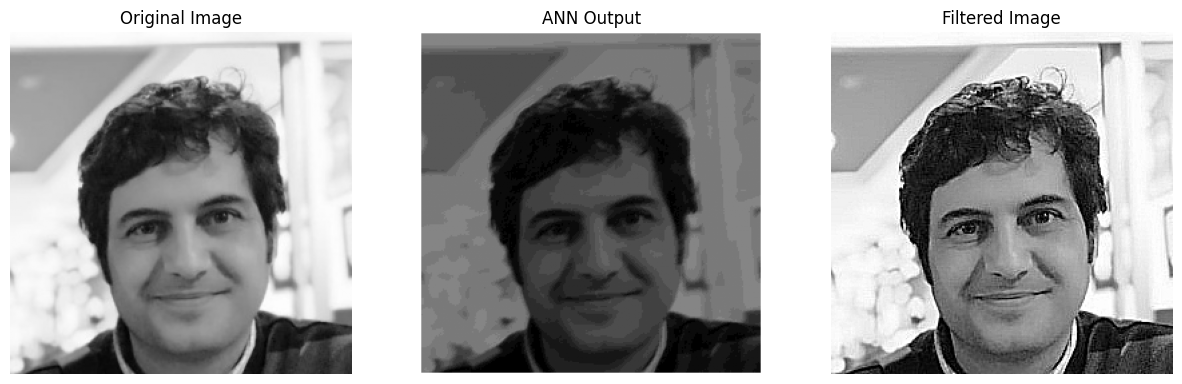

In [9]:
import matplotlib.pyplot as plt

# Test image and corresponding filtered image file paths
img_path = "a256sharporg/fn256org.jpeg"
filtered_path = "a256sharpfil/fn256sharp.png"

# Upload images (grayscale)
original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
filtered_img = cv2.imread(filtered_path, cv2.IMREAD_GRAYSCALE)

h, w = original_img.shape

# Normalize images
orig_norm = original_img.astype(np.float32) / 127.5 - 1.0

# Create a blank prediction picture (we will only do prediction excluding the edges)
predicted = np.zeros_like(orig_norm)

# Use the model_weights
model = FFANN().to(device)
model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    # Estimate for all pixels except edges
    for r in range(1, h - 1):
        for c in range(1, w - 1):
            # Extract 3x3 patch
            patch = orig_norm[r - 1:r + 2, c - 1:c + 2]
            patch = patch.flatten()
            patch_tensor = torch.from_numpy(patch).float().unsqueeze(0).to(device)
            output = model(patch_tensor)
            predicted[r, c] = output.item()

# Convert the predicted image from [-1, 1] scale back to 0-255 scale
predicted_denorm = ((predicted + 1.0) * 127.5).astype(np.uint8)

ann_output_path = "ann_output_img1.png"
cv2.imwrite(ann_output_path, predicted_denorm)
print(f"ANN output saved: {ann_output_path}")

# Visualize the results side by side
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(predicted_denorm, cmap="gray")
plt.title("ANN Output")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(filtered_img, cmap="gray")
plt.title("Filtered Image")
plt.axis("off")

plt.show()


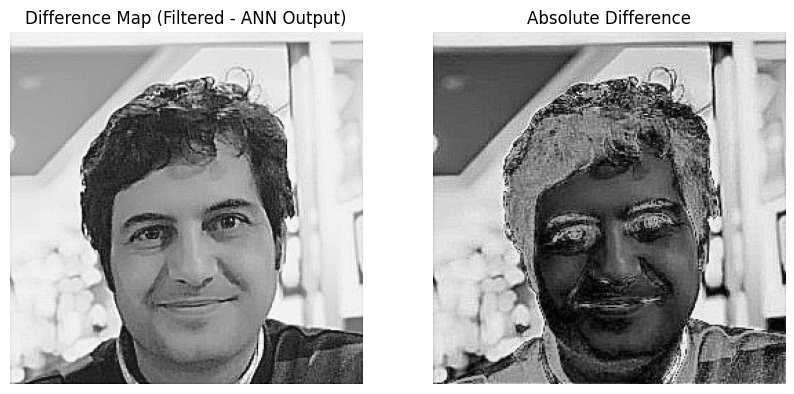

In [10]:
# 'predicted_denorm' = ANN output (in the range 0-255, uint8)
# 'filtered_img' = Actual filtered image (in the range 0-255, uint8)

# Convert to float
predicted_float = predicted_denorm.astype(np.float32)
filtered_float = filtered_img.astype(np.float32)

# Difference map (filtered - ANN_output)
difference_map = filtered_float - predicted_float

# Visualization
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(difference_map, cmap='gray')
plt.title("Difference Map (Filtered - ANN Output)")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(np.abs(difference_map), cmap='gray')
plt.title("Absolute Difference")
plt.axis('off')
plt.show()

In [11]:
from sklearn.neighbors import NearestNeighbors

class DiffPatchTable:
    def __init__(self, diff_map, patch_size=5):
        """
        diff_map: Difference map (filtered_img - ann_output), float32 or similar.
        patch_size: Patch size (5x5, 7x7, etc.)
        """
        self.patch_size = patch_size
        self.h, self.w = diff_map.shape
        half = patch_size // 2
        
        patches = []
        # We can keep a list of (row, col, patch_vector) to save patches.
        positions = []
        
        for r in range(half, self.h - half):
            for c in range(half, self.w - half):
                patch = diff_map[r - half:r + half + 1, c - half:c + half + 1]
                patch_flat = patch.flatten()
                patches.append(patch_flat)
                positions.append((r, c))
        
        # Convert to NumPy array
        self.patches = np.array(patches)  # (N, patch_size*patch_size)
        self.positions = positions
        
        # Create a model for k-NN (example: nearest 1 neighbor)
        self.nn_model = NearestNeighbors(n_neighbors=1, algorithm='auto')
        self.nn_model.fit(self.patches)
    
    def find_best_patch(self, query_patch):
        """
        query_patch: Diff patch vector at a new location.
        Returns: (best_patch, best_position)
        """
        distances, indices = self.nn_model.kneighbors([query_patch], n_neighbors=1)
        best_idx = indices[0, 0]
        return self.patches[best_idx], self.positions[best_idx]


In [12]:
def apply_style_with_knn(original_img, ann_output, diff_patch_table, patch_size=5):
    """
    original_img: Original (or ANN output) image as float32 (0..255) or [-1..1]
    ann_output: ANN output (same size)
    diff_patch_table: Previously created DiffPatchTable instance
    patch_size: Size of the patch
    """
    h, w = original_img.shape
    half = patch_size // 2
    
    # Final image
    final_stylized = ann_output.copy().astype(np.float32)
    
    for r in range(half, h - half):
        for c in range(half, w - half):
            # Here, we simply assume that we are looking for a patch similar to the ANN output.
            # In fact, the paper searches for a "difference" patch.
            # For simplicity, we perform k-NN on the ann_output patch.
            patch = ann_output[r - half:r + half + 1, c - half:c + half + 1]
            patch_flat = patch.flatten()
            
            # Find the nearest difference patch using k-NN
            best_diff_patch, _ = diff_patch_table.find_best_patch(patch_flat)
            best_diff_patch = best_diff_patch.reshape(patch_size, patch_size)
            
            # Update the pixels at the current location
            # (Formula from the paper: B'(x,y) = B"(x,y) + T(x,y))
            final_stylized[r, c] += best_diff_patch[half, half]
    
    # Clip values to the range 0..255
    final_stylized = np.clip(final_stylized, 0, 255).astype(np.uint8)
    return final_stylized


In [13]:
# 1) Training (or any) image pair: original & filtered
filtered_img_path = "a256sharpfil/fn256sharp.png"  # Actual filtered image
ann_output_path = "ann_output_img1.png"  # ANN output result

# 2) Load the images
filtered_img = cv2.imread(filtered_img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
ann_output  = cv2.imread(ann_output_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)

# 3) Calculate the difference map
diff_map = filtered_img - ann_output

# 4) Create the patch table (you can choose patch_size=5 or 7, etc.)
diff_table = DiffPatchTable(diff_map, patch_size=5)

In [14]:
# Original test image (grayscale)
test_img_path = "a256sharporg/fn256org.jpeg"
test_img = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)

# Assume ANN output (B") for the test image is obtained (load from file or predict on the fly):
ann_output_test_path = "ann_output_img1.png"
ann_output_test = cv2.imread(ann_output_test_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)


In [ ]:
# Apply texture synthesis
final_stylized = apply_style_with_knn(
    original_img=test_img,          # Test image (float32)
    ann_output=ann_output_test,     # ANN output (float32)
    diff_patch_table=diff_table,    # Table created in the previous step
    patch_size=5
)

# Save or visualize the result
cv2.imwrite("final_stylized_img1.png", final_stylized)
print("Texture synthesis completed, result saved.")
plt.imshow(final_stylized, cmap='gray')
plt.axis('off')
plt.show()